In [4]:
%matplotlib inline
import matplotlib
matplotlib.rcdefaults()

# Cayula-Cornillon

## Ideal Jet

A idealized meandering jets with rings, as a 2D numpy array (embeded in Xarray).

In [5]:
import matplotlib.pyplot as plt
import xarray as xr

from fronts_toolbox._fields import ideal_jet, sample
from fronts_toolbox.cayula_cornillon import cayula_cornillon_xarray

In [6]:
# A colormap for overlaying the detected fronts
from matplotlib.colors import ListedColormap

cmap_fronts = ListedColormap([(0, 0, 0, 0), (0, 0, 0, 1)])

In [7]:
sst = xr.DataArray(ideal_jet(), name="sst", dims=("lat", "lon"))
fronts = cayula_cornillon_xarray(sst)

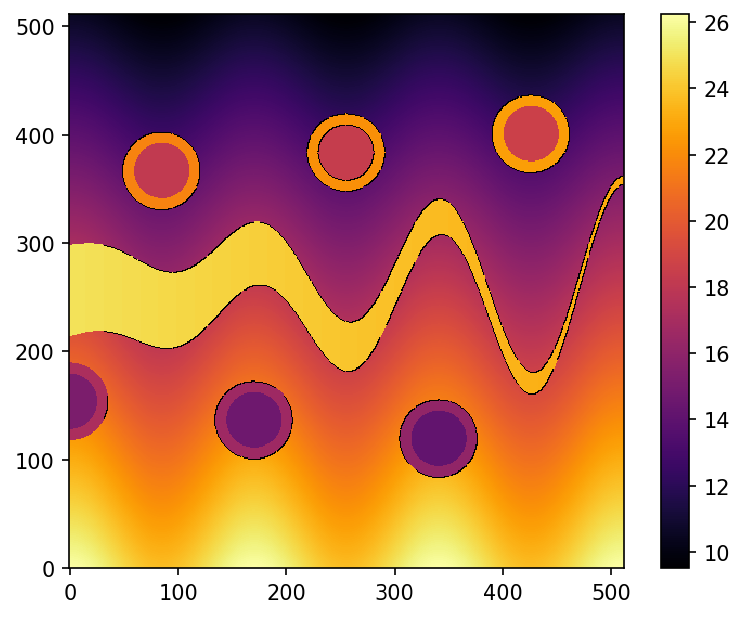

In [8]:
fig, ax = plt.subplots(dpi=150)

sst.plot.imshow(ax=ax, cmap="inferno", add_labels=False)
fronts.plot.imshow(ax=ax, cmap=cmap_fronts, add_labels=False, add_colorbar=False)
ax.set_aspect("equal")

## ESA-SST-CCI / C3S Data

SST of the North Atlantic, as a Dask array embeded in Xarray.

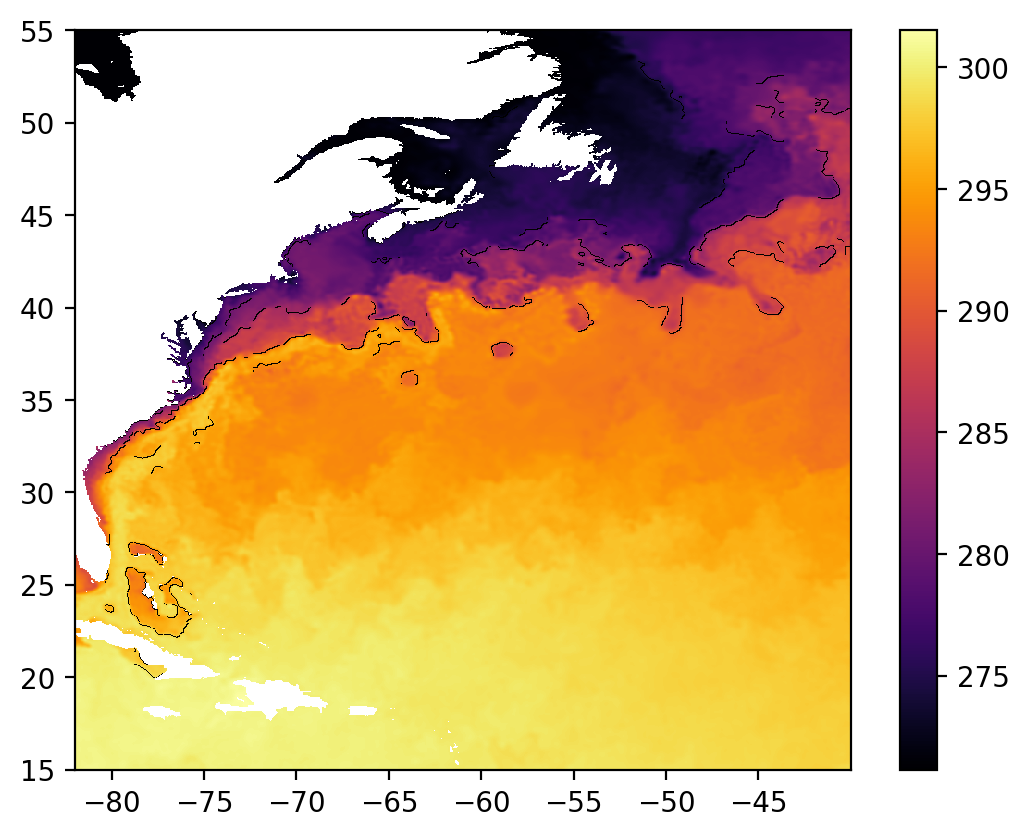

In [10]:
sst = (
    sample("ESA-CCI-C3S")
    .analysed_sst
    .sel(lat=slice(15, 55), lon=slice(-82, -40))
    .chunk(lat=256, lon=256)
)
fronts = cayula_cornillon_xarray(sst)

fig, ax = plt.subplots(dpi=200)

sst.isel(time=0).plot.imshow(
     ax=ax, cmap="inferno", add_labels=False, center=False
)
fronts.isel(time=0).plot.imshow(
     ax=ax, cmap=cmap_fronts, add_labels=False, add_colorbar=False
)

ax.set_aspect("equal")

## MODIS Data - Overlap

An example off the Californian coast with a window step smaller than its size, *ie* there is overlap between windows.

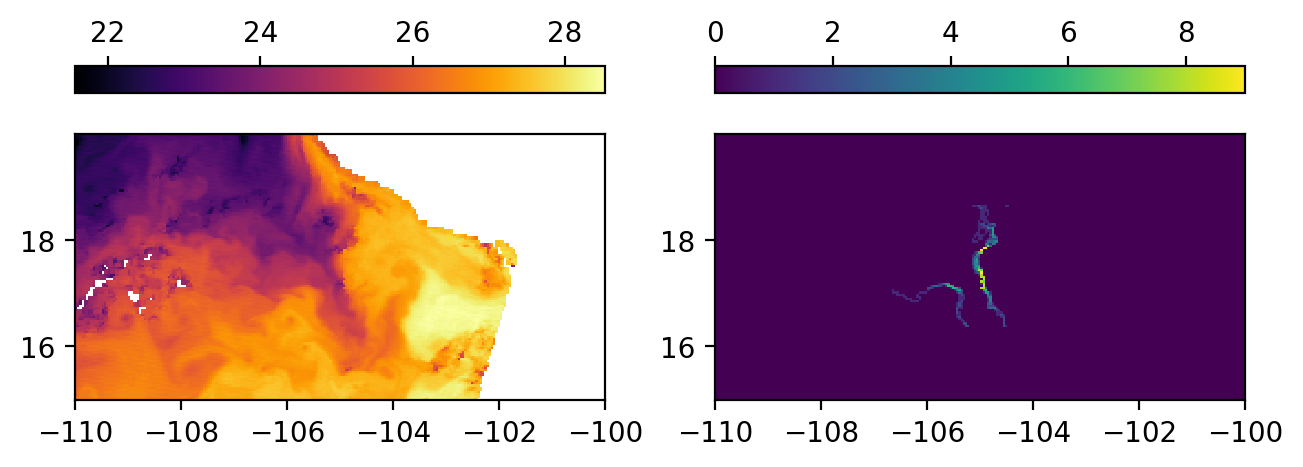

In [11]:
sst = (
    sample("MODIS")
    .sst4
    .isel(time=0)
    .sel(lat=slice(20, 15), lon=slice(-110, -100))
    .chunk(lat=256, lon=256)
)
fronts = cayula_cornillon_xarray(sst, window_size=32, window_step=8)

fig, axes = plt.subplots(1, 2, layout="constrained", dpi=200)

im_kw = dict(add_labels=False, cbar_kwargs=dict(location="top"))
sst.plot.imshow(ax=axes[0], cmap="inferno", center=False, **im_kw)
fronts.plot.imshow(ax=axes[1], cmap="viridis", **im_kw)

for ax in axes:
    ax.set_aspect("equal")